In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 90 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 31.16 MiB/s, done.
Resolving deltas: 100% (169/169), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./

In [2]:
from scipy.stats import norm
from tqdm.auto import tqdm, trange

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.optim import Adam


In [3]:
from dul_2021.utils.hw8_utils import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

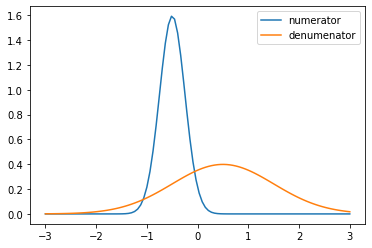

In [ ]:
# distributions

In [ ]:
class KernelMeanMatching(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.r = nn.Sequential(nn.Linear(1, 128), 
                               nn.ReLU(),
                               nn.Linear(128, 128), 
                               nn.ReLU(),
                               nn.Linear(128, 1),
                               nn.Softplus())
        self.sigma = sigma

    def get_kernel(self, x, y):
        ans = torch.exp(-(x - y.T) ** 2 / (2 * self.sigma))
        return ans
      
    def fit(self, loader_nu, loader_de, lr=1e-3, num_epochs=1000):
        optim = opt.Adam(self.r.parameters(), lr=lr)

        for epoch in tqdm(range(num_epochs)):
            for (batch_nu, batch_de) in zip(loader_nu, loader_de):
                batch_nu = batch_nu.float().to(device)
                batch_de = batch_de.float().to(device)
                
                r = self.r(batch_de)
                k_de_de = self.get_kernel(batch_de, batch_de)
                k_de_nu = self.get_kernel(batch_de, batch_nu)

                loss = (r.T.matmul(k_de_de).matmul(r) - 2 * r.T.matmul(k_de_nu).sum()) / batch_nu.shape[0] ** 2

                optim.zero_grad()
                loss.backward()
                optim.step()
    
    @torch.no_grad()
    def predict(self, batch):
        return self.r(batch).cpu().numpy()

In [ ]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution
    
    Returns
      - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """
    # your code goes here
    lr = 1e-3
    epochs = 100
    sigma = 0.1

    dataloader_nu = DataLoader(data_nu.reshape(-1, 1), batch_size=512, shuffle=True)
    dataloader_de = DataLoader(data_de.reshape(-1, 1), batch_size=512, shuffle=True)

    model = KernelMeanMatching(sigma).to(device)
    model.fit(dataloader_nu, dataloader_de, lr, epochs)

    # you need to calculate density ratio on x and return it
    x = np.linspace(-2., 2, num=100)
    x = torch.tensor(x.reshape(-1, 1), dtype=torch.float, device=device)

    return model.predict(x)  

100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


<Figure size 432x288 with 0 Axes>

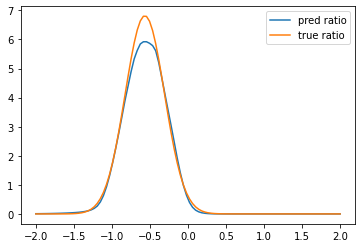

In [ ]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [5]:
class Classifier(nn.Module):
    def __init__(self, latent_dim=1, hidden_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128 + latent_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
  
    def forward(self, x, z):
        out = torch.flatten(self.conv(x), start_dim=1)
        return self.linear(torch.cat((out, z), dim=1))

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=1, noise_dim=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.linear = nn.Linear(4 * 4 * 128 + noise_dim, latent_dim)

        self.dist = torch.distributions.MultivariateNormal(
            torch.zeros(noise_dim, device=device),
            torch.eye(noise_dim, device=device)
        )

    def forward(self, x):
        out = torch.flatten(self.conv(x), start_dim=1)
        noise = self.dist.sample((x.shape[0],))
        return self.linear(torch.cat((out, noise), dim=1))

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128),
            nn.ReLU()
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1)
        )
  
    def forward(self, x):
        return self.conv(self.linear(x).reshape(x.shape[0], 128, 4, 4))

In [8]:
class AVB(nn.Module):
    def __init__(self, latent_dim, noise_dim):
        super().__init__()
        self.clf = Classifier(latent_dim)
        self.encoder = Encoder(latent_dim, noise_dim)
        self.decoder = Decoder(latent_dim)

        self.latent_dist = torch.distributions.MultivariateNormal(
            torch.zeros(latent_dim, device=device, dtype=torch.float),
            torch.eye(latent_dim, device=device, dtype=torch.float)
        )


    def get_loss(self, x):
        real = self.clf(x, self.encoder(x).detach()).squeeze()
        fake = self.clf(x, self.latent_dist.sample((x.shape[0],)).detach()).squeeze()

        l_1 = F.binary_cross_entropy_with_logits(real, torch.ones_like(real))
        l_2 = F.binary_cross_entropy_with_logits(fake, torch.zeros_like(fake))

        return l_1 + l_2


    def get_elbo_loss(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)

        bce = F.binary_cross_entropy_with_logits(x_rec, x, reduction="none").sum((-1, -2, -3)).mean()

        return self.clf(x, z.detach()).mean() + bce        


    @torch.no_grad()
    def test(self, test_loader):
        self.eval()
        elbo_losses, clf_losses = [], []

        for x in test_loader:
            x = x.to(device)

            elbo_loss = self.get_elbo_loss(x)
            clf_loss = self.get_loss(x)

            elbo_losses.append(elbo_loss.item())
            clf_losses.append(clf_loss.item())

        return np.mean(elbo_losses), np.mean(clf_losses)

    def fit(self, train_loader, test_loader, epochs=20, lr=1e-3):
        train_elbo, train_clf, test_elbo, test_clf = [], [], [], []

        ed_opt = Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=lr)
        clf_opt = Adam(self.clf.parameters(), lr=lr)

        for epoch in trange(epochs, desc="Training"):

            self.train()
            for x in train_loader:
                x = x.to(device)

                elbo_loss = self.get_elbo_loss(x)
                ed_opt.zero_grad()
                elbo_loss.backward()
                ed_opt.step()

                clf_loss = self.get_loss(x)
                clf_opt.zero_grad()
                clf_loss.backward()
                clf_opt.step()

                train_elbo.append(elbo_loss.item())
                train_clf.append(clf_loss.item())

            a, b = self.test(test_loader)
            test_elbo.append(a)
            test_clf.append(b)
          
        return train_elbo, train_clf, test_elbo, test_clf

    @torch.no_grad()
    def sample(self, n):
        return torch.sigmoid(self.decoder(self.latent_dist.sample((n,))))

In [9]:
def q2(train_data, test_data):
  """
  train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
   Returns
  - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
  - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
  - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
  """

  # your code goes here

  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)

  train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=256, shuffle=True)
    
  model = AVB(latent_dim=32, noise_dim=5).to(device)

  train_elbo, train_clf, test_elbo, test_clf = model.fit(train_loader, test_loader, epochs=20, lr=5e-4)

  return train_elbo, train_clf, test_elbo, test_clf, model.sample(100).detach().cpu().numpy()

Training:   0%|          | 0/20 [00:00<?, ?it/s]

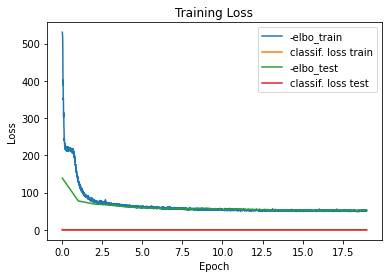

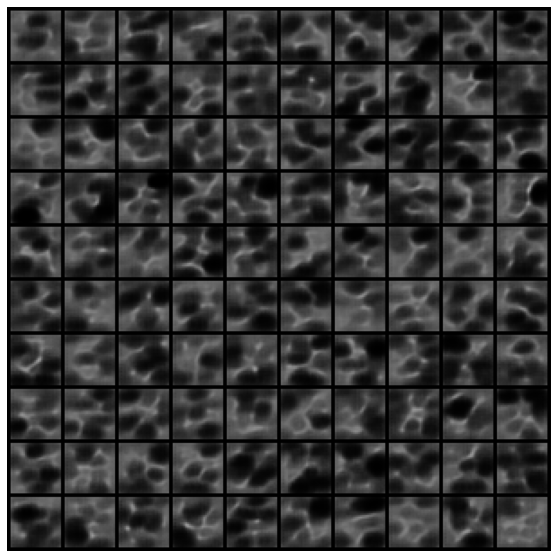

In [11]:
q2_results(q2)

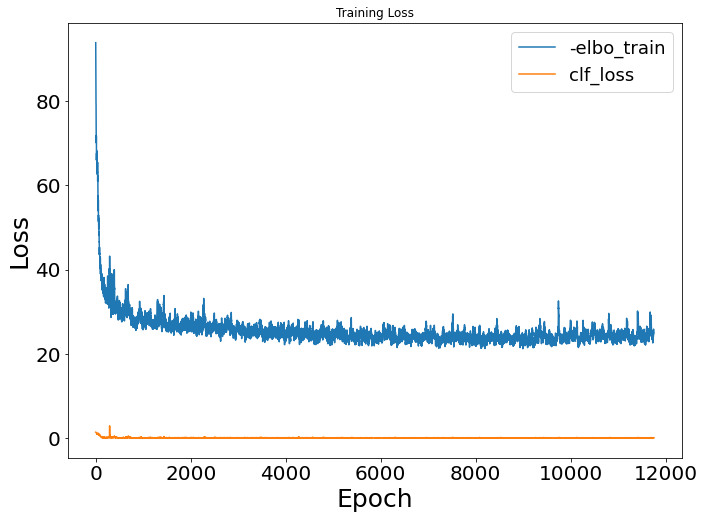

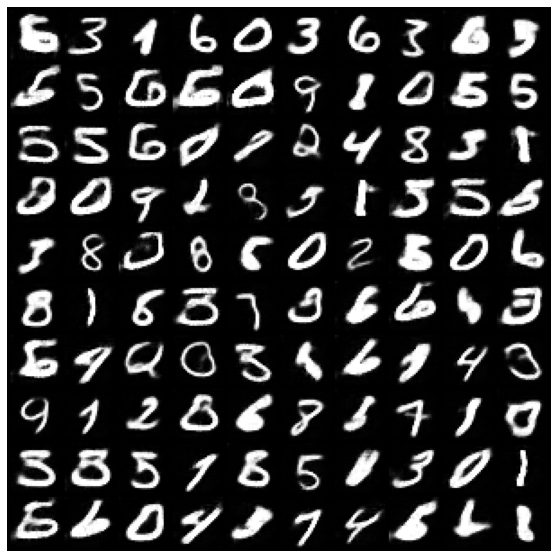

In [ ]:
q2_results(q2)